## **Per-Patch Classification: Xception based Classifier**
This notebook considers training and visualization of the per-patch classifier based on the Xception model.




In [1]:
    try: # Google Colab integration
        from google.colab import drive

        print('Colab environment detected. Mounting drive...')
        drive.mount('/content/drive')

        print('Mounted. Switching to directory... ', end = '')
        %cd /content/drive/'My Drive'/CILroadseg
        print('done.')
    except:
        print('Colab environment not found. Working on ordinary directory.')

Colab environment detected. Mounting drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mounted. Switching to directory... /content/drive/My Drive/CILroadseg
done.


In [2]:
import numpy as np
np.random.seed(1)

import tensorflow as tf

import sys
import os
import matplotlib.image as mpimg

from util.submit import *      # util/submit.py contains the functions used to generate the CSV file for Kaggle Competition
from util.visualize import *   # util/visualize.py provides functions for image visualization
from util.notebooks import *   # util/notebooks.py contains various util functions used in notebooks

# **Loading Training Data**
`nb_load_data` is an helper function provided in `util/notebooks.py`

In [3]:
train_dir = "training/images_additionaldata/"
gt_dir = "training/groundtruth_additionaldata/"
test_dir = "test/images/"
# here we use additional training data as mentioned in the report.
# use "training/images/" and "training/groundtruth" to
# reproduce the baseline Xception

X, Y, X_test = nb_load_data(train_dir, gt_dir, test_dir)
Y = (Y >= 0.25) * 1

Loading training input...
Progress: done (148 images).
Loading training groundtruth...
Progress: done (148 images).
Loading test input...
Progress: done (94 images).

       Training data shape: (148, 400, 400, 3)
Training groundtruth shape: (148, 400, 400)
           Test data shape: (94, 608, 608, 3)


# **Working with the Model**
The `XceptionModel` and `Decomposer` class are subclasses of `ModelBase`. This base class can be found in `util/model_base.py` and provides a common interface to all the models we created.

In particular:

`initialize()` resets the state of the object and should be called before the 

*   `initialize()` resets the state of the object and should be called before the training starts
*   `train(Y, X)` takes the training data X and its groundtruth Y to train the model
*   `classify(X)` returns the predictions for X
*   `load(filename)` and `save(filename)` load and save weights of the Neural Network from file.

The `Decomposer` class is a decorator which performs bootstrapping and data augmentation for all the per-patch classifiers (in this case `XceptionModel`).

The `Discretizer` decorator transforms the output of the inner model from [0, 1] to {0, 1} rounding to either 0 or 1 based on the given threshold.

One can allocate a model like below.

In [4]:
from decomposer import *
from discretize import * 
from xception import *
from rotate_mean import * 

Using TensorFlow backend.


In [5]:
model = XceptionModel()
# This is the core model. It takes windows and returns labels for patches.

model = RotAndMean(XceptionModel())
# This line can be commented out in order to use Xception without
# Rotate and Mean ensemble 

model = Decomposer(model, window_size=200)
# The decomposer decorator takes full images. During training phase
# it does data augmentation and window sampling, while during
# prediction it divides the images in windows and passes them
# to the inner model.

model = Discretizer(model, threshold=0.5)

DO_TRAINING = False
if DO_TRAINING:
  model.initialize()
  model.train(Y, X)

  model.save("saves/final/xception.h5")
else:
  model.initialize()
  model.load("saves/final/xception-additionaldata.h5")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 100352)            20861480  
_________________________________________________________________
dense_1 (Dense)              (None, 64)                6422592   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 27,288,297
Trainable params: 27,233,769
Non-trainable params: 54,528
_____________________________________

# **Making Predictions with the Model**
`Decomposer.classify(X)` decomposes the images of X into windows and then calls `XceptionModel.classify(X)` to do the patchwise classification, but it does not recompose the images. This is true for all the patchwise classifiers we created, because having patchwise predictions can be useful in certain cases.

If you want the model to return full masks, you need to wrap it into a `Recomposer` decorator, as below. The implementation of this decorator class can be found in `recomposer.py.`

In [6]:
from recomposer import *
model = Recomposer(model)

The function `nb_predict_masks` is an helper function provided in `util/notebooks.py`, while `masks_to_submission` is a function based on the implementation provided in the Kaggle competition.

The following two cells can be skipped if you do not want to generate the `.csv` file.

**Warning:** Mask prediction for Xception may need more than 12 GB of RAM, and takes a while.

In [7]:
test_masks_dir = "test/pred/"
test_dir = "test/images/"

nb_predict_masks(model, test_dir, test_masks_dir)

Predicting test cases... 
Progress: done.


In [9]:
image_paths = [test_masks_dir + file for file in os.listdir(test_masks_dir)]

masks_to_submission("test/pred/xception.csv", image_paths)

# **Visualizing predictions**
The function view_image_array is provided in `util/visualize.py`. It uses `matplotlib` to visualize the images and the corresponding predictions.

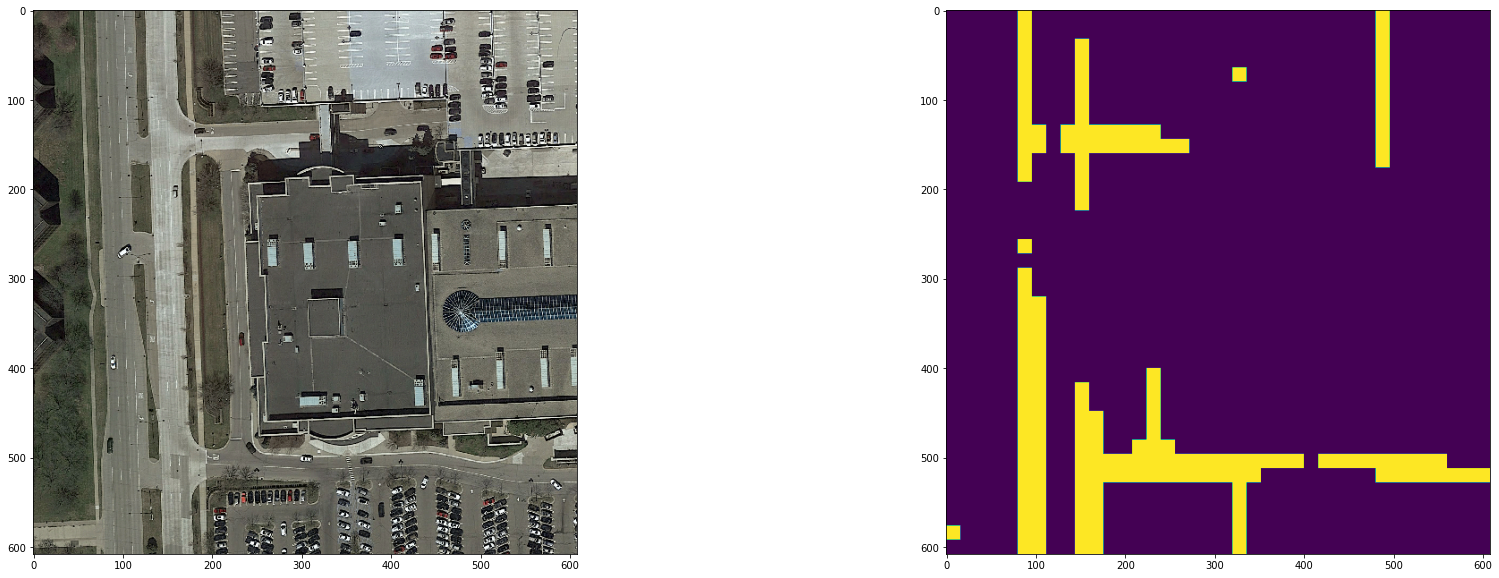

In [10]:
Xt = X_test[0:1]

Y_pred = model.classify(Xt)

view_image_array(Xt, Y_pred)